# Packages and lib imports

In [45]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [47]:
# configs
model_name = 'mu-0.39__700ds__UnetWithSkips__30epochs'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b/1000samples_50mu'
ds_subdir = 'mu=0.39'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [48]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [49]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [50]:
print(len(trainer.val_dataset))

300


In [51]:
#pretty print ds config


Visualizer.print_config(trainer.val_dataset.config)

{
    "W": 0.05,
    "Nspans": 12,
    "La": 80,
    "M_QAM": 16,
    "Ts": 1.0,
    "Nos": 16,
    "eta": 2,
    "mu": 0.3938775510204082,
    "bet": 0.2,
    "with_ssf": true,
    "with_noise": true,
    "beta2": -21.0,
    "gamma": 1.27,
    "dz": 0.2,
    "K_T": 1.13,
    "chi": 0.0461,
    "verbose": false,
    "io_type": "b",
    "N_sc": 256,
    "T_guardband": 4750.0880922277665,
    "N_sc_raw": 237.50440461138834,
    "L": 960,
    "T0": 5120.0,
    "Tb": 10240.0,
    "Tn": 1358.1221810508403,
    "Zn": 87833.13612677579,
    "Pn": 8.964743939765935e-06
}


# analyze 1 sample

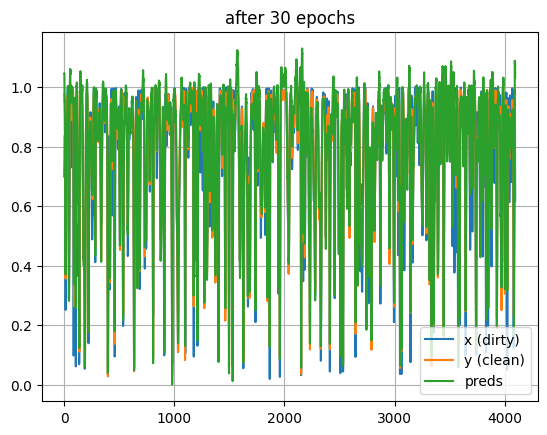

In [52]:
# ma.plot_single_item(1)
ma.plot_single_item_together(1)

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

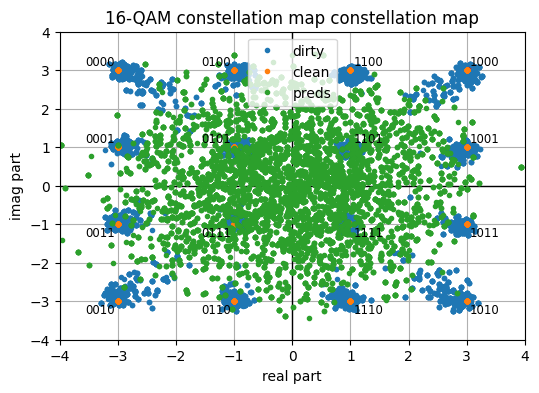

In [53]:
ma.plot_constelation(range(0,40))

In [23]:
x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

  0%|          | 0/300 [00:00<?, ?it/s]

x_power: 2566.8976017252644
y_power: 2725.66103515625
pred_power: 13.440566949844357


In [24]:
# ma.upload_single_item_plots_to_wandb(1)

In [25]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/300 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.003662109375


  0%|          | 0/300 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.38810546875
the ber improvement is -10497.87%


In [ ]:
ma.upload_bers_to_wandb()

# test all BERs

In [ ]:
# add powers

from apps.deep.power_adder import PowerAdder


main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
power_adder = PowerAdder(is_overright=True, verbose_level=2)
power_adder.add_to_all(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

In [ ]:
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=1, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [ ]:
# print model's architecture
# TODO - make sure every model has this method (make abstract model class that all inherit from)
# trainer.model.print_architecture

# THE END

In [ ]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [ ]:
# analyze on the whole dataset

# attach new dataset to trainer


In [ ]:
trainer.params

In [ ]:
ma = ModelAnalyzer(trainer)

In [ ]:
ma.plot_single_item(i=0)

In [ ]:
ma.plot_bers(_tqdm=tqdm)